
# Enhanced Data Understanding — Hotel Reservations (2023 & 2024)

**What this notebook contains**
- Merges `hotel_reservations_2023.csv` and `hotel_reservations_2024.csv` (adds `year` column).
- Full Data Understanding phase (collection, exploration, quality assessment, profiling, metadata usage).
- Visualizations with interpretations after each result.
- Advanced analysis: outlier detection, PCA, clustering, and a RandomForest for feature importance (to surface predictors of cancellations).
- The notebook is defensive: if CSVs are missing, it will explain what to place and continue with available files.

> Run each cell in order. If you run this in a new environment, ensure the CSV files and the data dictionary are in the same folder as this notebook.


In [2]:

# Imports and environment checks
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

print('Working directory:', os.getcwd())
print('Files available:')
for f in os.listdir('.'):
    print(' -', f)


Working directory: c:\Users\chams\OneDrive\Bureau\BI\Hôtellerie\Hôtellerie\Practice Files Hotel Reservation
Files available:
 - .ipynb_checkpoints
 - hotel_reservations_2023.xlsx
 - hotel_reservations_2024.xlsx
 - hotel_reservations_clean_merged.csv
 - hotel_reservations_data_dictionary.csv
 - hotel_reservations_data_understanding.ipynb


In [3]:

# Paths
file_2023 = "hotel_reservations_2023.xlsx"
file_2024 = "hotel_reservations_2024.xlsx"
data_dict_file = "hotel_reservations_data_dictionary.csv"

# Load with defensive checks
dfs = {}
for name, path in [("2023", file_2023), ("2024", file_2024)]:
    if os.path.exists(path):
        try:
            dfs[name] = pd.read_excel(path, engine='openpyxl')
            print(f"Loaded {path} -> shape:", dfs[name].shape)
        except Exception as e:
            print(f"Error loading {path}:", e)
    else:
        print(f"File not found: {path}")

# Load data dictionary if present
if os.path.exists(data_dict_file):
    try:
        data_dict = pd.read_csv(data_dict_file)
        print("Loaded data dictionary -> shape:", data_dict.shape)
    except Exception as e:
        print("Error loading data dictionary:", e)
else:
    data_dict = None
    print("Data dictionary not found:", data_dict_file)


Loaded hotel_reservations_2023.xlsx -> shape: (50000, 23)
Loaded hotel_reservations_2024.xlsx -> shape: (42000, 23)
Loaded data dictionary -> shape: (23, 2)



## Merge 2023 & 2024 datasets
We will combine the two datasets, adding a `year` column so we can compare year-over-year trends.


In [4]:

# Merge if both are available
if "2023" in dfs and "2024" in dfs:
    df_2023 = dfs["2023"].copy()
    df_2024 = dfs["2024"].copy()
    df_2023['year'] = 2023
    df_2024['year'] = 2024
    df = pd.concat([df_2023, df_2024], ignore_index=True)
    print("Combined dataframe shape:", df.shape)
else:
    # If only one exists, use what's available
    if "2023" in dfs:
        df = dfs["2023"].copy(); df['year'] = 2023
        print("Only 2023 present. Using 2023. Shape:", df.shape)
    elif "2024" in dfs:
        df = dfs["2024"].copy(); df['year'] = 2024
        print("Only 2024 present. Using 2024. Shape:", df.shape)
    else:
        df = pd.DataFrame()
        print("No dataset available. Please upload CSVs.")


Combined dataframe shape: (92000, 24)



## Step 1 & 2 — Basic Overview and Initial Exploration

We print shape, dtypes, and a few top rows. An interpretation follows each result.


In [5]:

if df.empty:
    print("No data to explore yet. Please add the CSV files and re-run.")
else:
    display(df.head())
    print('\nDataframe shape:', df.shape)
    print('\nDataframe dtypes:')
    print(df.dtypes.value_counts())
    # Interpretation markdown will follow in a separate cell.


,Guest ID,Guest Name,Nationality,Contact Phone,Reservation ID,Check-In Date,Check-Out Date,Room Type,Booking Channel,Payment Method,...,Special Requests,Amenities Used,Stay Reason,Cancellation Status,Extra Services Costs ($),Guest Rating (1-5),Customer Review,Loyalty Member,Visit Frequency,year
0,GUEST-00001,Eric Green,South Africa,-3012,RES-00001,2023-07-14,2023-07-15,Suite,Walk-In,Cash,...,Late check-in,Wi-Fi,Wedding,No,290.41,2.0,Wonderful service!,Silver,First-time,2023
1,GUEST-00002,Lisa Larsen,Saudi Arabia,-3013,RES-00002,2023-05-26,2023-05-31,Double,Corporate,Cash,...,Crib,Wi-Fi,Wedding,No,415.60,5.0,Average experience,Silver,First-time,2023
2,GUEST-00003,Karen Wade,Germany,-7607,RES-00003,NaT,NaT,Double,Online (Booking),Credit Card,...,NaN,NaN,Conference,Yes,0.00,NaN,NaN,NaN,First-time,2023
3,GUEST-00004,Tracy Gardner,Indonesia,-8547,RES-00004,NaT,NaT,Family,Online (Expedia),Credit Card,...,NaN,NaN,Wedding,Yes,0.00,NaN,NaN,NaN,First-time,2023
4,GUEST-00005,Ms. Amy Reed,Switzerland,-6411,RES-00005,2023-12-16,2023-12-17,Family,Online (Expedia),Credit Card,...,NaN,Mini Bar,Business,No,375.72,2.0,Average experience,Platinum,Returning,2023



Dataframe shape: (92000, 24)

Dataframe dtypes:
object            15
int64              3
datetime64[ns]     3
float64            3
Name: count, dtype: int64



**Interpretation (Initial):**

- The `shape` tells how many reservations and features we have — this indicates dataset size and informs processing choices (memory, sampling).
- Knowing the number of numerical vs categorical columns helps pick appropriate profiling and imputation strategies.



## Step 3 — Missing Values & Completeness

We compute missing value counts and visualize missingness to identify problematic columns.


,missing_count,missing_pct
Loyalty Member,53187,57.81
Special Requests,49973,54.32
Guest Rating (1-5),39604,43.05
Amenities Used,39603,43.05
Customer Review,39601,43.04
Number of Guests,39530,42.97
Check-In Date,38906,42.29
Check-Out Date,38906,42.29
Extra Services Costs ($),15302,16.63


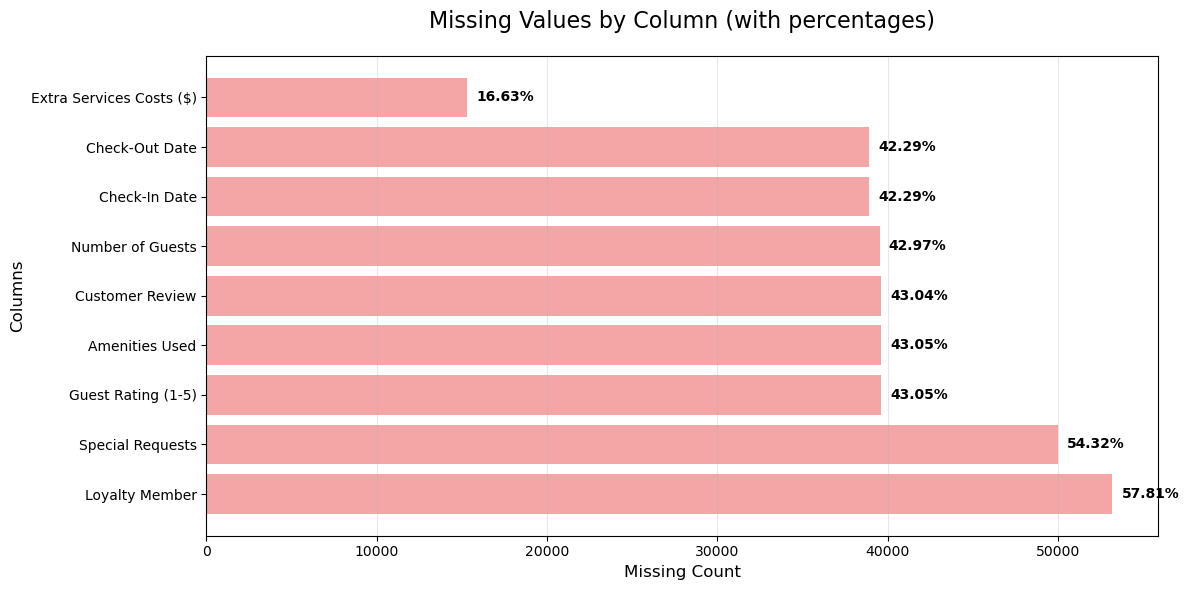

In [6]:
if not df.empty:
    missing = df.isnull().sum().sort_values(ascending=False)
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.concat([missing, missing_pct], axis=1, keys=['missing_count','missing_pct'])
    display(missing_df[missing_df['missing_count']>0].head(50))
    
    cols_with_missing = missing[missing > 0]
    missing_pct_filtered = missing_pct[missing_pct > 0]
    
    if not cols_with_missing.empty:
        plt.figure(figsize=(12, max(6, len(cols_with_missing) * 0.5)))
        
        # Create horizontal bar chart
        y_pos = range(len(cols_with_missing))
        bars = plt.barh(y_pos, cols_with_missing.values, color='lightcoral', alpha=0.7)
        
        # Add percentage annotations
        for i, (count, pct) in enumerate(zip(cols_with_missing.values, missing_pct_filtered.values)):
            plt.text(count + max(cols_with_missing) * 0.01, i, f'{pct}%', 
                    va='center', fontweight='bold')
        
        plt.title('Missing Values by Column (with percentages)', fontsize=16, pad=20)
        plt.xlabel('Missing Count', fontsize=12)
        plt.ylabel('Columns', fontsize=12)
        plt.yticks(y_pos, cols_with_missing.index)
        plt.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No missing values found in the dataset.")
else:
    print("No data to analyze.")



**Interpretation (Missingness):**

- Columns with high missing percentage may be unusable or require special treatment (imputation, categorical 'Unknown', or removal).



## Step 4 — Categorical Profiling

For key categorical columns we show frequency tables and bar plots with interpretations.


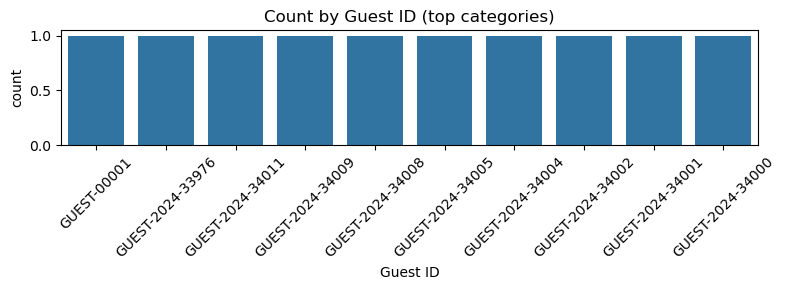

Guest ID
GUEST-00001         1
GUEST-2024-33976    1
GUEST-2024-34011    1
GUEST-2024-34009    1
GUEST-2024-34008    1
GUEST-2024-34005    1
GUEST-2024-34004    1
GUEST-2024-34002    1
GUEST-2024-34001    1
GUEST-2024-34000    1
Name: count, dtype: int64


--- Interpretation ---
Guest ID: top category = GUEST-00001 (0.00% of rows)




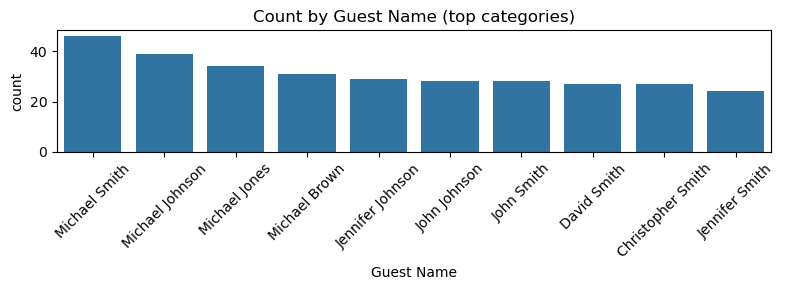

Guest Name
Michael Smith        46
Michael Johnson      39
Michael Jones        34
Michael Brown        31
Jennifer Johnson     29
John Johnson         28
John Smith           28
David Smith          27
Christopher Smith    27
Jennifer Smith       24
Name: count, dtype: int64


--- Interpretation ---
Guest Name: top category = Michael Smith (0.05% of rows)




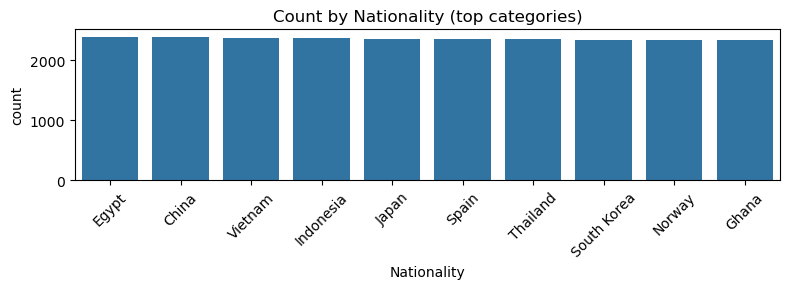

Nationality
Egypt          2397
China          2382
Vietnam        2366
Indonesia      2366
Japan          2355
Spain          2348
Thailand       2348
South Korea    2342
Norway         2341
Ghana          2340
Name: count, dtype: int64


--- Interpretation ---
Nationality: top category = Egypt (2.61% of rows)




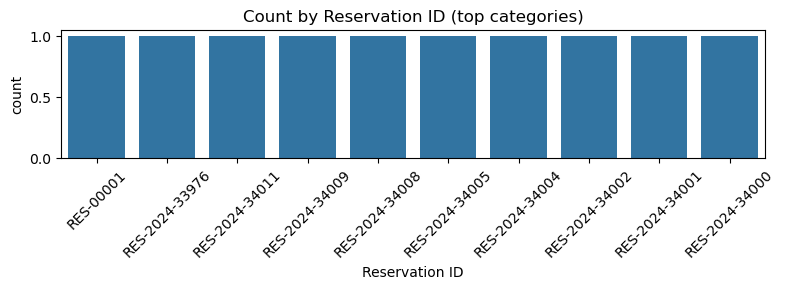

Reservation ID
RES-00001         1
RES-2024-33976    1
RES-2024-34011    1
RES-2024-34009    1
RES-2024-34008    1
RES-2024-34005    1
RES-2024-34004    1
RES-2024-34002    1
RES-2024-34001    1
RES-2024-34000    1
Name: count, dtype: int64


--- Interpretation ---
Reservation ID: top category = RES-00001 (0.00% of rows)




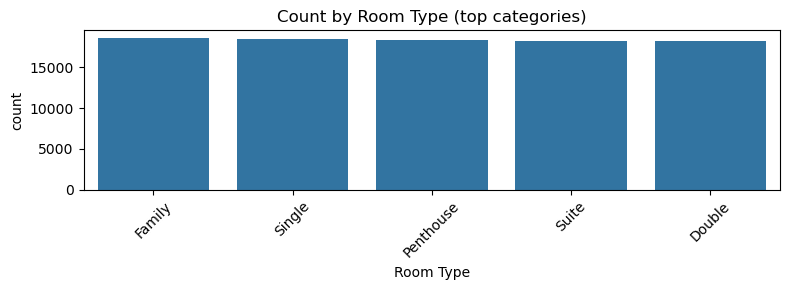

Room Type
Family       18621
Single       18527
Penthouse    18375
Suite        18268
Double       18209
Name: count, dtype: int64


--- Interpretation ---
Room Type: top category = Family (20.24% of rows)




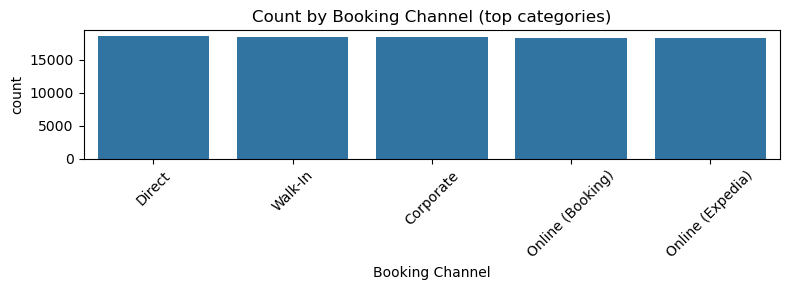

Booking Channel
Direct              18517
Walk-In             18500
Corporate           18494
Online (Booking)    18253
Online (Expedia)    18236
Name: count, dtype: int64


--- Interpretation ---
Booking Channel: top category = Direct (20.13% of rows)




In [7]:

if not df.empty:
    # pick top categorical columns by cardinality and presence
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    # ensure we also include some known categorical-looking numeric columns if present
    extra_cats = [c for c in ['hotel','meal','market_segment','distribution_channel','reserved_room_type','deposit_type','customer_type'] if c in df.columns and c not in cat_cols]
    cat_cols = extra_cats + cat_cols
    cat_cols = list(dict.fromkeys(cat_cols))  # preserve order unique
    cat_cols = cat_cols[:6]  # limit for readability
    
    for c in cat_cols:
        plt.figure(figsize=(8,3))
        order = df[c].value_counts().nlargest(10).index if c in df.columns else []
        sns.countplot(data=df, x=c, order=order)
        plt.title(f'Count by {c} (top categories)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        display(df[c].value_counts(dropna=False).head(10))
        print('\n--- Interpretation ---')
        if df[c].dtype == 'object' or df[c].dtype.name=='category':
            top = df[c].value_counts(normalize=True, dropna=False).nlargest(1)
            print(f'{c}: top category = {top.index[0]} ({top.iloc[0]*100:.2f}% of rows)')
        print('\n')
else:
    print("No data present.")



**Interpretation (Categorical):**

- Dominant categories show where the business activity is concentrated (e.g., a dominant `market_segment` means reliance on that channel).
- Rare categories may be grouped into 'Other' to avoid sparse levels in models.



## Numeric Profiling, Distributions & Outliers

We inspect numeric distributions and use boxplots to surface outliers.


Numeric columns sample: ['Contact Phone', 'Total Amount ($)', 'Lead Time (days)', 'Extra Services Costs ($)', 'Guest Rating (1-5)', 'year']


,count,mean,std,min,25%,50%,75%,max
Contact Phone,92000.0,-6563.777500,2615.047404,-11508.00,-8822.00,-6568.000,-4308.0000,-1570.00
Total Amount ($),92000.0,2544.053814,1414.082510,100.08,1317.59,2549.160,3763.1275,4999.91
Lead Time (days),92000.0,30.435685,17.294665,1.00,16.00,30.000,45.0000,60.00
Extra Services Costs ($),76698.0,153.761302,163.847495,0.00,0.00,88.295,293.2475,499.99
Guest Rating (1-5),52396.0,2.997194,1.415391,1.00,2.00,3.000,4.0000,5.00
year,92000.0,2023.456522,0.498109,2023.00,2023.00,2023.000,2024.0000,2024.00


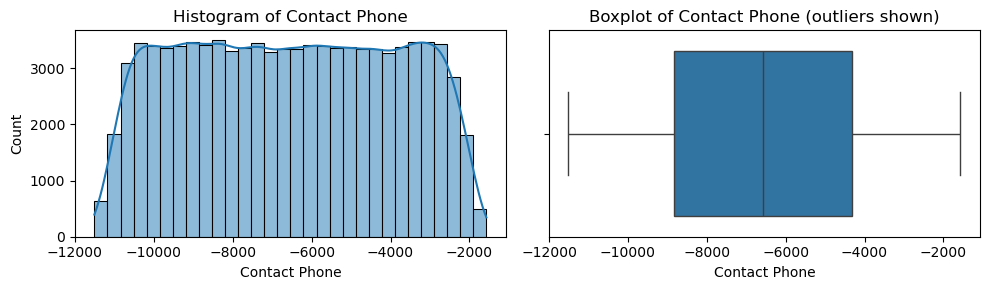

Contact Phone: potential outliers count = 0
--- Interpretation ---
No significant anomalies were identified under the IQR rule.




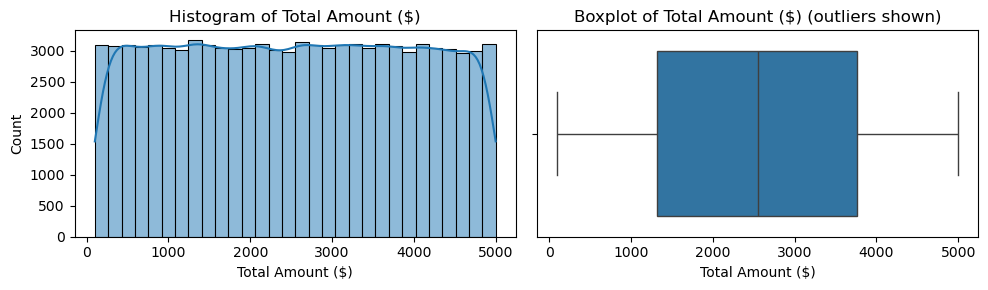

Total Amount ($): potential outliers count = 0
--- Interpretation ---
No significant anomalies were identified under the IQR rule.




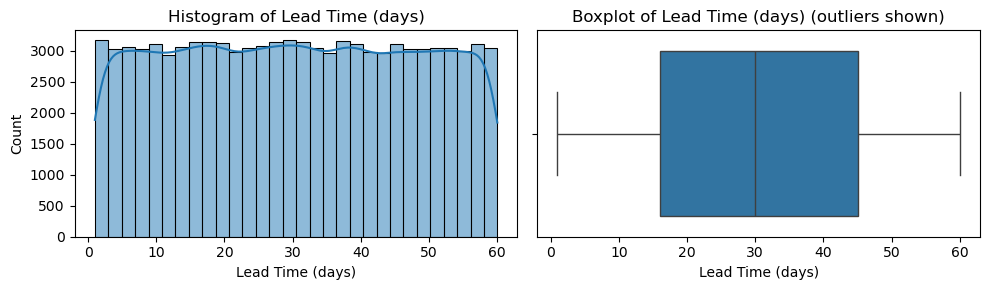

Lead Time (days): potential outliers count = 0
--- Interpretation ---
No significant anomalies were identified under the IQR rule.




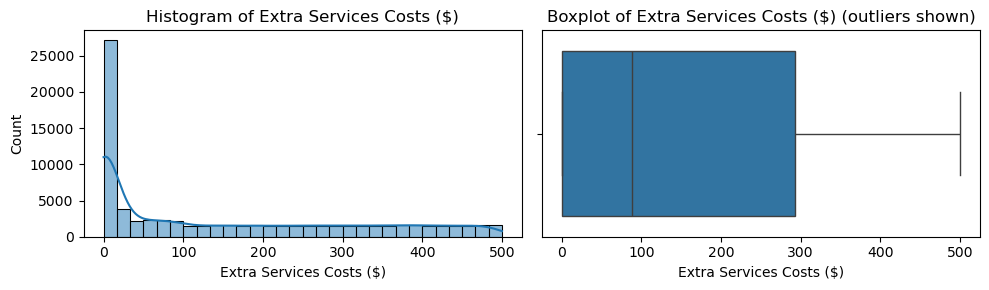

Extra Services Costs ($): potential outliers count = 0
--- Interpretation ---
No significant anomalies were identified under the IQR rule.




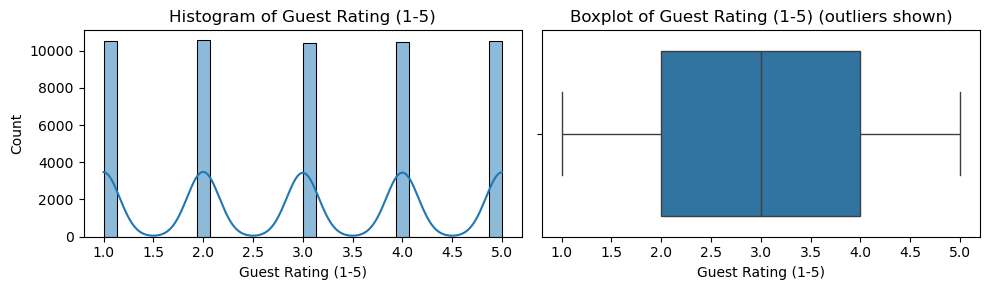

Guest Rating (1-5): potential outliers count = 0
--- Interpretation ---
No significant anomalies were identified under the IQR rule.




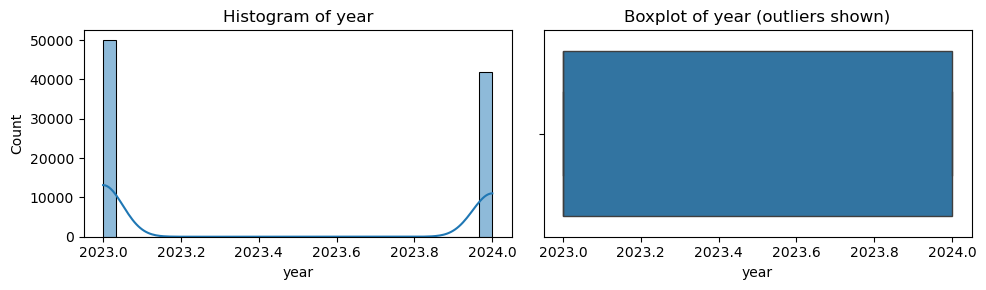

year: potential outliers count = 0
--- Interpretation ---
No significant anomalies were identified under the IQR rule.




In [8]:

if not df.empty:
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    print('Numeric columns sample:', num_cols[:10])
    display(df[num_cols].describe().transpose())
    
    # Histograms for up to 6 numeric columns
    for c in num_cols[:6]:
        plt.figure(figsize=(10,3))
        plt.subplot(1,2,1)
        sns.histplot(df[c].dropna(), bins=30, kde=True)
        plt.title(f'Histogram of {c}')
        plt.subplot(1,2,2)
        sns.boxplot(x=df[c].dropna())
        plt.title(f'Boxplot of {c} (outliers shown)')
        plt.tight_layout()
        plt.show()
        
        # simple outlier rule (IQR)
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        outliers = df[(df[c] < q1 - 1.5*iqr) | (df[c] > q3 + 1.5*iqr)][c]
        print(f'{c}: potential outliers count =', outliers.shape[0])
        print('--- Interpretation ---')
        if outliers.shape[0] > 0:
            print('Outliers may indicate data-entry errors or exceptional stays (e.g., very high ADR). Consider capping or investigating specific records.')
        else:
            print('No significant anomalies were identified under the IQR rule.')
        print('\n')
else:
    print("No data present.")


# Generate clean version

In [11]:
# Save as Excel file
df_clean = df.copy()
output_path = "hotel_reservations_clean_merged.xlsx"
df_clean.to_excel(output_path, index=False)

print(f"✅ Clean merged dataset exported for Power BI: {output_path}")
df_clean.head()


✅ Clean merged dataset exported for Power BI: hotel_reservations_clean_merged.xlsx


,Guest ID,Guest Name,Nationality,Contact Phone,Reservation ID,Check-In Date,Check-Out Date,Room Type,Booking Channel,Payment Method,...,Special Requests,Amenities Used,Stay Reason,Cancellation Status,Extra Services Costs ($),Guest Rating (1-5),Customer Review,Loyalty Member,Visit Frequency,year
0,GUEST-00001,Eric Green,South Africa,-3012,RES-00001,2023-07-14,2023-07-15,Suite,Walk-In,Cash,...,Late check-in,Wi-Fi,Wedding,No,290.41,2.0,Wonderful service!,Silver,First-time,2023
1,GUEST-00002,Lisa Larsen,Saudi Arabia,-3013,RES-00002,2023-05-26,2023-05-31,Double,Corporate,Cash,...,Crib,Wi-Fi,Wedding,No,415.60,5.0,Average experience,Silver,First-time,2023
2,GUEST-00003,Karen Wade,Germany,-7607,RES-00003,NaT,NaT,Double,Online (Booking),Credit Card,...,NaN,NaN,Conference,Yes,0.00,NaN,NaN,NaN,First-time,2023
3,GUEST-00004,Tracy Gardner,Indonesia,-8547,RES-00004,NaT,NaT,Family,Online (Expedia),Credit Card,...,NaN,NaN,Wedding,Yes,0.00,NaN,NaN,NaN,First-time,2023
4,GUEST-00005,Ms. Amy Reed,Switzerland,-6411,RES-00005,2023-12-16,2023-12-17,Family,Online (Expedia),Credit Card,...,NaN,Mini Bar,Business,No,375.72,2.0,Average experience,Platinum,Returning,2023
